# Homework 2

### Due Date: Friday, March 20

### Policy Gradient

In this assignment, we will implement vanilla policy gradient algorithm (REINFORCE) covered in the lecture. You will work on i) a function approximator, ii) computing action, iii) collecting samples, iV) training the agent, V) plotting the resutls. 


***Complete the missing operations and test your implemented algorithm on the Gym environment.***

***Software requirements:***
- Python >= 3.6
- Tensorflow version <= 1.15.3 (1.X version)
- OpenAI Gym

- Training the agent (policy) can take long time. It is recomended to start solving the problems earlier.

- Save any plots you generated in this notebook. The grade will be given based on the plots you showed.



Make sure the packages you installed meet the requirements.

In [1]:
import tensorflow as tf
tf.__version__

C:\Users\marie\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\marie\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\marie\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\marie\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

'1.13.1'

In [2]:
import gym
gym.__version__

'0.18.0'

## 1.1 Tensorflow Implementation

We will be implementing policy gradient algorithm using Tensorflow 1.X., which simply updates the parameters of policy from obtaining gradient estimates. The core of policy gradient is to design a function approximator, computing actions, collecting samples, and training the policy. In the below cell, you are encouraged to fill in the components that are missing. ***Your tasks*** are 

1. Complete the 'create_model' method to output the mean value for diagonal Guassian policy. Covariance is already defined in the model, so focus on creating neural network model.

2. Complete the 'action_op' method to calculate and return the actions for diagonal Gaussian policy. The applied action should be $\pi(s) = \pi_{\text{mean}}(s) + exp(logstd) * \mathcal{N}(0,1)$

***Hints***:
- Some useful tensorflow classes and methods include: 'tf.exp', 'tf.random_normal'



In [7]:
import tensorflow as tf
import numpy as np
import os
import ipdb


class PolicyOpt(object):

    def __init__(self, env, linear=False, stochastic=True, hidden_size=32, nonlinearity=tf.nn.relu):
        """Instantiate the policy iteration class.

        This initializes the policy optimization with a set of trainable 
        parameters, and creates a tensorflow session.

        Attributes
        ----------
        env : gym.Env
            the environment that the policy will be trained on
        linear : bool, optional
            specifies whether to use a linear or neural network 
            policy, defaults to False (i.e. Fully-Connected-Neural-Network)
        stochastic : bool, optional
            specifies whether to use a stochastic or deterministic 
            policy, defaults to True
        hidden_size : list of int, optional
            list of hidden layers, with each value corresponding 
            to the number of nodes in that layer 
        nonlinearity : tf.nn.*
            activation nonlinearity
        """
        
        # clear computation graph
        tf.reset_default_graph()
        
        # set a random seed
        tf.set_random_seed(1234)
        
        # start a tensorflow session
        self.sess = tf.Session()
        
        # environment to train on
        self.env = env
        
        # number of elements in the action space
        self.ac_dim = env.action_space.shape[0]
        
        # number of elements in the observation space
        self.obs_dim = env.observation_space.shape[0]

        # actions placeholder
        self.a_t_ph = tf.placeholder(dtype=tf.float32, 
                                     shape=[None, self.ac_dim])
        # state placeholder
        self.s_t_ph = tf.placeholder(dtype=tf.float32, 
                                     shape=[None, self.obs_dim])
        # expected reward placeholder
        self.rew_ph = tf.placeholder(dtype=tf.float32, 
                                     shape=[None])

        # specifies whether the policy is stochastic
        self.stochastic = stochastic

        # policy that the agent executes during training/testing
        self.policy = self.create_model(
            args={
                "num_actions": self.ac_dim,
                "hidden_size": hidden_size,
                "linear": linear,
                "nonlinearity": nonlinearity,
                "stochastic": stochastic,
                "scope": "policy",
            }
        )
        
        # define symbolic action
        self.symbolic_action = self.action_op()

        # initialize all variables
        self.sess.run(tf.global_variables_initializer())

        # create saver to save model variables
        self.saver = tf.train.Saver()

    def create_model(self, args):
        """Create a model for your policy or other components.

        Parameters
        ----------
        args : dict
            model-specific arguments, with keys:
              - "stochastic": True by default
              - "hidden_size": Number of neurons in hidden layer
              - "num_actions" number of output actions
              - "scope": scope of the model

        Returns
        -------
        tf.Variable
            mean actions of the policy
        tf.Variable 
            logstd of the policy actions
        """

#################### Build Your Neural Network Here! ####################        
        
        input_size = self.obs_dim
        hidden_size = args["hidden_size"]
        output_size = args["num_actions"]
        
        weights_0 = tf.Variable(tf.random_normal([input_size, hidden_size]))
        bias_0 = tf.Variable(tf.random_normal([hidden_size]))
        weights_1 = tf.Variable(tf.random_normal([hidden_size, hidden_size]))
        bias_1 = tf.Variable(tf.random_normal([hidden_size]))
        weights_2 = tf.Variable(tf.random_normal([hidden_size, output_size]))
        bias_2 = tf.Variable(tf.random_normal([output_size]))

        hidden_layer1 = tf.nn.tanh(tf.matmul(self.s_t_ph, weights_0) + bias_0)
        hidden_layer2 = tf.nn.tanh(tf.matmul(hidden_layer1, weights_1) + bias_1)
        output_mean = tf.matmul(hidden_layer2, weights_2) + bias_2
        
##########################################################################        

        if args["stochastic"]:
            output_logstd =  tf.get_variable(name="action_logstd",shape=[self.ac_dim],trainable=True)
        else:
            output_logstd = None
            
        return output_mean, output_logstd
    
    def action_op(self):
        """
        Create a symbolic expression that will be used to compute actions from observations.

        When the policy is stochastic, the action follows 

            a_t = output_mean + exp(output_logstd) * z; z ~ N(0,1)
        """
        if self.stochastic:
            output_mean, output_logstd = self.policy

            #################### Implement a stochastic policy here ####################        
            # Implement a stochastic version of computing actions.       #
            #                                                            #
            # The action in a stochastic policy represented by           #
            # a diagonal Gaussian distribution with mean "M" and log     #
            # standard deviation "logstd" is computed as follows:        #
            #                                                            #
            #     a = M + exp(logstd) * z                                #
            #                                                            #
            # where z is a random normal value, i.e. z ~ N(0,1)          #
            #                                                            #
            # In order to generate numbers from a normal distribution,   #
            # use the `tf.random_normal` function.                       #     
            ############################################################################ 
            z = tf.random_normal(shape=[self.ac_dim])
            symbolic_action = output_mean + (tf.exp(output_logstd) * z)
            
        else:
            symbolic_action, _ = self.policy
        
        return symbolic_action

    def compute_action(self, obs):
        """Returns a list of actions for a given observation.

        Parameters
        ----------
        obs : np.ndarray
            observations

        Returns
        -------
        np.ndarray
            actions by the policy for a given observation
        """
        return self.sess.run(self.symbolic_action,feed_dict={self.s_t_ph: obs})

    def rollout(self, s_mean=None, s_std=None):
        """Collect samples from one rollout of the policy.

        Returns
        -------
        dict
            dictionary containing trajectory information for the rollout,
            specifically containing keys for "state", "action", "next_state", "reward", and "done"
        """
        states = []
        next_states = []
        actions = []
        rewards = []
        dones = []

        # start a new rollout by re-setting the environment and collecting the initial state
        state =  self.env.reset()

        steps = 0
        while True:
            steps += 1

            # compute the action given the state
            if s_mean is not None and s_std is not None:
                action = self.compute_action([(state - s_mean) / s_std])
            else:
                action = self.compute_action([state])
            action = action[0]

            # advance the environment once and collect the next state, reward, done, and info parameters from the environment
            next_state, reward, done, info =  self.env.step(action)

            # add to the samples list
            states.append(state)
            actions.append(action)
            next_states.append(next_state)
            rewards.append(reward)
            dones.append(done)

            state = next_state

            # if the environment returns a True for the done parameter,
            # end the rollout before the time horizon is met
            if done or steps > env._max_episode_steps:
                break

        # create the output trajectory
        trajectory = {"state": np.array(states, dtype=np.float32),
                      "reward": np.array(rewards, dtype=np.float32),
                      "action": np.array(actions, dtype=np.float32),
                      "next_state": np.array(next_states, dtype=np.float32),
                      "done": np.array(dones, dtype=np.float32)}

        return trajectory

    def train(self, args):
        """Abstract training method.

        This method will be filled in by algorithm-specific
        training operations in subsequent problems.

        Parameters
        ----------
        args : dict
            algorithm-specific hyperparameters
        """
        raise NotImplementedError

## 1.2 Tensorflow Interpretation

In order to test your implementation of the **stochastic policy**, run the below cell. The task is to interpret the code you implemented in previous section. If you implement correctly, you can see the value_1 and value_2.

***Question: How do you interpret value_1 and value_2 below cell?***


In [8]:
import gym
TEST_ENV = gym.make("Pendulum-v0")

alg = PolicyOpt(TEST_ENV, linear=False)
input_1 = [[0, 1, 2]]
value_1 = alg.sess.run(alg.policy[0], feed_dict={alg.s_t_ph: input_1})
value_2 = alg.compute_action(input_1)

In [9]:
value_1

array([[-14.081912]], dtype=float32)

Answer: value_1 is the result of the neural network. It is trying to find the best policy. So it wants to approximate the correlation between the two possible actions (go left/go right). 

In [10]:
value_2

array([[-14.624967]], dtype=float32)

Answer: value_2 is the prediction for the next action. It gives us the force/length and direction we want to push the cart at.

## 1.3 Implement Policy Gradient

In this section, we will implement REINFORCE algorithm presented in the lecture. As a review, the objective is optimize the parameters $\theta$ of some policy $\pi_\theta$ so that the expected return

\begin{equation}
J(\theta) = \mathbb{E} \bigg\{ \sum_{t=0}^T \gamma^t r(s_{t},a_{t}) \bigg\}
\end{equation}

is optimized. In this algorithm, this is done by calculating the gradient $\nabla_\theta J$ and applying a gradient descent method to find a better policy.

\begin{equation}
\theta ' = \theta + \alpha \nabla_\theta J(\theta)
\end{equation}

In the lecture, we derive how we compute $\nabla_{\theta} J(\theta)$. We can rewrite our policy gradient as:

\begin{equation}
\nabla_\theta J (\theta) \approx \frac{1}{N} \sum_{i=0}^{N} \bigg( \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta (a_{it} | s_{it}) \bigg) \bigg( \sum_{t=0}^T \gamma^{t}r_i(t) \bigg)
\end{equation}

Finally, taking into account the causality principle discussed in class, we are able to simplifiy the gradient estimate such as:

\begin{equation}
\nabla_\theta J (\theta) \approx \frac{1}{N} \sum_{i=0}^{N} \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta (a_{it} | s_{it}) \sum_{t'=t}^T \gamma^{t'-t}r_i(t')
\end{equation}

You will be implementing final expression in this assignment!



The process of REINFORCE algorithm follows:

1. Collect samples from current policy $\pi_\theta(s)$ by executing rollouts of the environment.
2. Calculate an estimate for the expected return at state $s_t$. 
3. Compute the log-likelihood of each action that was performed by the policy at every given step.
4. Estimate the gradient and update the parameters of policy using gradient-based technique.
5. Repeat steps 1-4 for a number of training iterations.

***Your task*** is to fill out the skeleton code for REINFORCE algorithm,

1. Complete the 'log_likelihoods' method to compute gradient of policy, $\nabla_{\theta}\pi_{\theta}$ for diagonal Guassian policy. 

2. Complete the 'compute_expected_return' method to calculate the reward-to-go, $\sum_{t^{\prime}=t}^{T}$. 



In [11]:
import tensorflow as tf
import numpy as np
import time
import tensorflow_probability as tfp

class REINFORCE(PolicyOpt):

    def train(self, num_iterations=1000, steps_per_iteration=1000, learning_rate=int(1e-4), gamma=0.95, 
              **kwargs):
        """Perform the REINFORE training operation.

        Parameters
        ----------
        num_iterations : int
            number of training iterations
        steps_per_iteration : int
            number of individual samples collected every training iteration
        learning_rate : float
            optimizer learning rate
        gamma : float
            discount rate
        kwargs : dict
            additional arguments

        Returns
        -------
        list of float
            average return per iteration
        """
        # set the discount as an attribute
        self.gamma = gamma
        
        # set the learning rate as an attribute
        self.learning_rate = learning_rate

        # create a symbolic expression to compute the log-likelihoods 
        log_likelihoods = self.log_likelihoods()

        # create a symbolic expression for updating the parameters of your policy
        self.opt, self.opt_baseline = self.define_updates(log_likelihoods)
        
        # initialize all variables
        self.sess.run(tf.global_variables_initializer())


        # average return per training iteration
        ret_per_iteration = []
        
        samples = []
        for i in range(num_iterations):
            
            # collect samples from the current policy
            samples.clear()
            steps_so_far = 0
            while steps_so_far < steps_per_iteration:
                new_samples = self.rollout()
                steps_so_far += new_samples["action"].shape[0]
                samples.append(new_samples)

            # compute the expected returns
            v_s = self.compute_expected_return(samples)

            # compute and apply the gradients
            self.call_updates(log_likelihoods, samples, v_s, **kwargs)

            # compute the average cumulative return per iteration
            average_rew = np.mean([sum(s["reward"]) for s in samples])

            # display iteration statistics
            print("Iteration {} return: {}".format(i, average_rew))
            ret_per_iteration.append(average_rew)

        return ret_per_iteration

    def log_likelihoods(self):
        """Create a tensorflow operation that computes the log-likelihood 
        of each performed action.
        """
        
        output_mean, output_logstd = self.policy

        ##############################################################
        # Create a tf operation to compute the log-likelihood of     #
        # each action that was performed by the policy               #
        #                                                            #
        # The log likelihood in the continuous case where the policy #
        # is expressed by a multivariate gaussian can be computing   #
        # using the tensorflow object:                               #
        #                                                            #
        #    p = tfp.distributions.MultivariateNormalDiag(           #
        #        loc=...,                                            #
        #        scale_diag=...,                                     #
        #    )                                                       #
        #                                                            #
        # This method takes as input a mean (loc) and standard       #
        # deviation (scale_diag), and then can be used to compute    #
        # the log-likelihood of a variable as follows:               #
        #                                                            #
        #    log_likelihoods = p.log_prob(...)                       #
        #                                                            #
        # For this operation, you will want to use placeholders      #
        # created in the __init__ method of problem 1.               #
        ##############################################################

        p = tfp.distributions.MultivariateNormalDiag(loc = output_mean, scale_diag = tf.exp(output_logstd))
        log_likelihoods = p.log_prob(self.a_t_ph)
                                     
        return log_likelihoods

    def compute_expected_return(self, samples):
        """Compute the expected return from a given starting state.
        This is done by using the reward-to-go method.

        Parameters
        ----------
        rewards : list of list of float
            a list of N trajectories, with each trajectory contain T 
            returns values (one for each step in the trajectory)

        Returns
        -------
        list of float, or np.ndarray
            expected returns for each step in each trajectory
        """
        rewards = [s["reward"] for s in samples]

        ##############################################################
        # Estimate the expected return from any given starting state #
        # using the reward-to-go method.                             #
        #                                                            #
        # Using this method, the reward is estimated at every step   #
        # of the trajectory as follows:                              #
        #                                                            #
        #   r = sum_{t'=t}^T gamma^(t'-t) * r_{t'}                   #
        #                                                            #
        # where T is the time horizon at t is the index of the       #
        # current reward in the trajectory. For example, for a given #
        # set of rewards r = [1,1,1,1] and discount rate gamma = 1,  #
        # the expected reward-to-go would be:                        #
        #                                                            #
        #   v_s = [4, 3, 2, 1]                                       #
        #                                                            #
        # You will be able to test this in one of the cells below!   #
        ##############################################################
            
        v_s = []
        for r in rewards:
            for t in range(0,len(r)):
                s = []
                for t_prime in range(t,len(r)):
                    v = (self.gamma**(t_prime - t))*r[t_prime]
                    s.append(v)
                v_s.append(sum(s))
        
        return v_s

    def define_updates(self, log_likelihoods):
        """Create a tensorflow operation to update the parameters of 
        your policy.

        Parameters
        ----------
        log_likelihoods : tf.Operation
            the symbolic expression you created to estimate the log 
            likelihood of a set of actions

        Returns
        -------
        tf.Operation
            a tensorflow operation for computing and applying the 
            gradients to the parameters of the policy
        None
            the second component is used in problem 2.b, please ignore 
            for this problem
        """

        loss = - tf.reduce_mean(tf.multiply(log_likelihoods, self.rew_ph))
        opt = tf.train.AdamOptimizer(self.learning_rate).minimize(loss)

        return opt, None

    def call_updates(self, log_likelihoods, samples, v_s, **kwargs):
        """Apply the gradient update methods in a tensorflow session.

        Parameters
        ----------
        log_likelihoods: tf.Operation
            the symbolic expression you created to estimate the log 
            likelihood of a set of actions
        samples : list of dict
            a list of N trajectories, with each trajectory containing 
            a dictionary of trajectory data (see self.rollout)
        v_s : list of float, or np.ndarray
            the estimated expected returns from your
            `comput_expected_return` function 
        kwargs : dict
            additional arguments (used in question 3)
        """
        # concatenate the states
        states = np.concatenate([s["state"] for s in samples])

        # concatenate the actions
        actions = np.concatenate([s["action"] for s in samples])

        # execute the optimization step
        self.sess.run(self.opt, feed_dict={self.s_t_ph: states,
                                           self.a_t_ph: actions,
                                           self.rew_ph: v_s})


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



Check your 'log_likelihoods' method by running below cell:

In [12]:
alg = REINFORCE(TEST_ENV, stochastic=True)

log_likelihoods = alg.log_likelihoods()

# collect a sample output for a given input state
input_s = [[0, 0, 0], [0, 1, 2], [1, 2, 3]]
input_a = [[0], [1], [2]]

# Check
computed = alg.sess.run(log_likelihoods, feed_dict={alg.a_t_ph: input_a, alg.s_t_ph: input_s})

Test your 'compute_expected_return' by running below cell:

In [13]:
# 1. Test the non-normalized case
alg = REINFORCE(TEST_ENV, stochastic=True)
alg.gamma = 1.0
    
input_1 = [{"reward": [1, 1, 1, 1]},
           {"reward": [1, 1, 1, 1]}]
vs_1 = alg.compute_expected_return(samples=input_1)
ans_1 = np.array([4, 3, 2, 1, 4, 3, 2, 1])

if np.linalg.norm(vs_1 - ans_1) < 1e-3:
    print('Great job!')
else:
    print('Check your implementation (compute_expected_return)')

Great job!


## 1.4 Testing your algorithm

When you are ready, test your policy gradient algorithms on the *Pendulum-v0* environment in the cell below. *Pendulum-v0* environment is similar to *off-shore wind power*, the goal here is to maintain the Pendulum is upright using control input. The best policy should get around -200 scores. ***Your task*** is to run your REINFORCE algorithm and plot the result!


In [14]:
# set this number as 1 for testing your algorithm, and 3 for plotting
NUM_TRIALS = 3

# ===========================================================================
# Do not modify below line
# ===========================================================================

# we will test the algorithms on the Pendulum-v0 gym environment
import gym
env = gym.make("Pendulum-v0")

# train on the REINFORCE algorithm
import numpy as np
r = []
for i in range(NUM_TRIALS):
    print("\n==== Training Run {} ====".format(i))
    alg = REINFORCE(env, stochastic=True)
    res = alg.train(learning_rate=0.005, gamma=0.95, num_iterations=500, steps_per_iteration=15000)
    r.append(np.array(res))
    alg = None

# save results
np.savetxt("InvertedPendulum_results.csv", np.array(r), delimiter=",")


==== Training Run 0 ====
Instructions for updating:
Use tf.cast instead.
Iteration 0 return: -1433.3766188729305
Iteration 1 return: -1316.2228602067396
Iteration 2 return: -1272.5197135861156
Iteration 3 return: -1199.6790235775213
Iteration 4 return: -1183.7781424172022
Iteration 5 return: -1142.5316480240972
Iteration 6 return: -1081.8212143131593
Iteration 7 return: -1007.7732437769572
Iteration 8 return: -896.8280852767701
Iteration 9 return: -949.13621082386
Iteration 10 return: -1015.5325556937853
Iteration 11 return: -1013.4983159799377
Iteration 12 return: -966.0591182210048
Iteration 13 return: -964.62100365373
Iteration 14 return: -963.1397121451423
Iteration 15 return: -1006.5133760105322
Iteration 16 return: -987.1348517999363
Iteration 17 return: -928.7974521261112
Iteration 18 return: -1029.0223850598559
Iteration 19 return: -1049.958002875621
Iteration 20 return: -1076.9462912912325
Iteration 21 return: -1073.0467853496968
Iteration 22 return: -1057.4282495984933
Itera

Iteration 196 return: -869.197575658684
Iteration 197 return: -883.6634633524529
Iteration 198 return: -1004.1978317373184
Iteration 199 return: -925.1171295090703
Iteration 200 return: -882.701363953619
Iteration 201 return: -825.7567992953708
Iteration 202 return: -800.0858829930797
Iteration 203 return: -780.0419767728075
Iteration 204 return: -781.5860630630391
Iteration 205 return: -780.4221686641375
Iteration 206 return: -768.950244003584
Iteration 207 return: -756.2340725183611
Iteration 208 return: -733.8963835384759
Iteration 209 return: -715.2112966154764
Iteration 210 return: -710.2813562153776
Iteration 211 return: -821.2055401451389
Iteration 212 return: -970.1031488783036
Iteration 213 return: -1018.7061549646284
Iteration 214 return: -1029.933586411352
Iteration 215 return: -1044.3792183332641
Iteration 216 return: -1070.8618680560216
Iteration 217 return: -1091.098092089047
Iteration 218 return: -1089.6583444617936
Iteration 219 return: -1094.502108783722
Iteration 220 

Iteration 396 return: -276.6920400570209
Iteration 397 return: -248.51756400878153
Iteration 398 return: -282.94630112955656
Iteration 399 return: -271.24546995058813
Iteration 400 return: -253.26768977959173
Iteration 401 return: -230.11563421989558
Iteration 402 return: -252.21648703964348
Iteration 403 return: -243.22245555226147
Iteration 404 return: -227.73918333572956
Iteration 405 return: -224.95621835637334
Iteration 406 return: -237.16963958549198
Iteration 407 return: -232.4517601028077
Iteration 408 return: -246.23870840975724
Iteration 409 return: -243.52546845716657
Iteration 410 return: -245.65532458894245
Iteration 411 return: -215.7642914543909
Iteration 412 return: -255.87577732033324
Iteration 413 return: -243.09180810880721
Iteration 414 return: -217.83724452876123
Iteration 415 return: -253.38011190569688
Iteration 416 return: -247.24601687326643
Iteration 417 return: -235.99634454707987
Iteration 418 return: -216.86399420790005
Iteration 419 return: -255.0199324484

Iteration 95 return: -1267.3534155700038
Iteration 96 return: -1304.9623827963205
Iteration 97 return: -1338.5210689312817
Iteration 98 return: -1212.396100466422
Iteration 99 return: -1273.581431542078
Iteration 100 return: -1292.5280162022832
Iteration 101 return: -1237.9400911269947
Iteration 102 return: -1261.413207559393
Iteration 103 return: -1267.407098319375
Iteration 104 return: -1263.4271773189337
Iteration 105 return: -1228.3898929540187
Iteration 106 return: -1235.1973919519353
Iteration 107 return: -1230.6816591921538
Iteration 108 return: -1235.2830142254884
Iteration 109 return: -1264.705856260278
Iteration 110 return: -1316.6455381590904
Iteration 111 return: -1200.3512735143033
Iteration 112 return: -1165.4917245815213
Iteration 113 return: -1220.2560942343218
Iteration 114 return: -1259.2862242794145
Iteration 115 return: -1167.411697985946
Iteration 116 return: -1198.3269905189154
Iteration 117 return: -1216.8043914403684
Iteration 118 return: -1188.3416041140495
Ite

Iteration 293 return: -394.18610299030473
Iteration 294 return: -369.86688038861234
Iteration 295 return: -340.5257624367182
Iteration 296 return: -396.8857891341237
Iteration 297 return: -342.27906130854507
Iteration 298 return: -375.33967023747044
Iteration 299 return: -361.30555607470336
Iteration 300 return: -388.8026340928627
Iteration 301 return: -405.3985461205186
Iteration 302 return: -398.5451247807468
Iteration 303 return: -293.7678560334183
Iteration 304 return: -346.9427081268135
Iteration 305 return: -263.0892380132872
Iteration 306 return: -302.88138283148953
Iteration 307 return: -283.769065325039
Iteration 308 return: -369.6498487242513
Iteration 309 return: -352.8132793833292
Iteration 310 return: -374.108977137603
Iteration 311 return: -300.1093282158401
Iteration 312 return: -348.43676206055386
Iteration 313 return: -374.605891963649
Iteration 314 return: -354.14277206119965
Iteration 315 return: -304.5923255674638
Iteration 316 return: -334.5503152884927
Iteration 3

Iteration 491 return: -251.81287614830381
Iteration 492 return: -300.7448998606825
Iteration 493 return: -218.9340848599431
Iteration 494 return: -295.26662787360885
Iteration 495 return: -269.6045404490788
Iteration 496 return: -204.27490756682727
Iteration 497 return: -227.49780921241307
Iteration 498 return: -217.07769882449108
Iteration 499 return: -242.07583070910687

==== Training Run 2 ====
Iteration 0 return: -1418.7280267525712
Iteration 1 return: -1410.1455714190758
Iteration 2 return: -1397.4544528017466
Iteration 3 return: -1404.0299949816863
Iteration 4 return: -1386.4879190498964
Iteration 5 return: -1388.1300904958869
Iteration 6 return: -1382.619259838667
Iteration 7 return: -1362.49319661206
Iteration 8 return: -1349.3655443524467
Iteration 9 return: -1345.5702334592252
Iteration 10 return: -1320.3214032079663
Iteration 11 return: -1327.9311829147434
Iteration 12 return: -1295.3222996088239
Iteration 13 return: -1342.0122830709008
Iteration 14 return: -1329.55628750001

Iteration 191 return: -208.3857318834812
Iteration 192 return: -208.96341073338706
Iteration 193 return: -228.56766240304947
Iteration 194 return: -216.07654339285554
Iteration 195 return: -246.89265783893183
Iteration 196 return: -214.58763903470046
Iteration 197 return: -225.9815535866733
Iteration 198 return: -241.4544806263364
Iteration 199 return: -227.86154895656995
Iteration 200 return: -236.94715449127125
Iteration 201 return: -273.28787358786457
Iteration 202 return: -249.0693113372028
Iteration 203 return: -241.59851857449155
Iteration 204 return: -265.25097995162935
Iteration 205 return: -233.85808878262907
Iteration 206 return: -194.71685035451847
Iteration 207 return: -224.6734264365586
Iteration 208 return: -215.4034969100985
Iteration 209 return: -241.35654815300208
Iteration 210 return: -239.22127114735068
Iteration 211 return: -224.9678619421572
Iteration 212 return: -228.1037934763519
Iteration 213 return: -227.73733314118863
Iteration 214 return: -250.48445304331224


Iteration 388 return: -225.5709316444791
Iteration 389 return: -245.56181794009908
Iteration 390 return: -251.8751715237533
Iteration 391 return: -230.89210081318083
Iteration 392 return: -250.9005606467719
Iteration 393 return: -261.7375591566674
Iteration 394 return: -271.7672129297959
Iteration 395 return: -236.15055959494163
Iteration 396 return: -216.5531817913164
Iteration 397 return: -197.44848633828107
Iteration 398 return: -211.09854848775043
Iteration 399 return: -251.08133335910108
Iteration 400 return: -183.00554787539903
Iteration 401 return: -223.53241375970532
Iteration 402 return: -206.14494776164702
Iteration 403 return: -199.73649212126713
Iteration 404 return: -232.3381484368752
Iteration 405 return: -192.1241797980412
Iteration 406 return: -226.06749368450681
Iteration 407 return: -215.79634165405227
Iteration 408 return: -221.1198650755842
Iteration 409 return: -239.0461752709622
Iteration 410 return: -221.17294166729786
Iteration 411 return: -244.9855544774762
Ite

Text(0.5, 1.0, 'Progression of average reward by number of iterations')

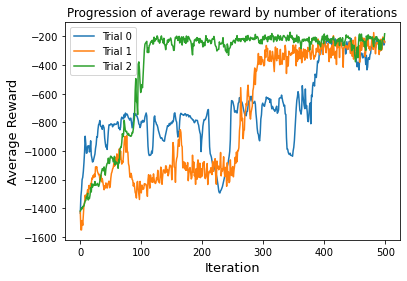

In [15]:
# collect saved results
import numpy as np
r1 = np.genfromtxt("InvertedPendulum_results.csv", delimiter=",")
all_results = [r1]
labels = ["REINFORCE"]

##############################################################
# Plot your Policy Gradient results below
##############################################################
import matplotlib.pyplot as plt
for i in range(len(all_results[0])):
    plt.plot(all_results[0][i], label=f"Trial {i}")
plt.legend()
plt.xlabel("Iteration", fontsize=13)
plt.ylabel("Average Reward", fontsize=13)
plt.title("Progression of average reward by number of iterations")